In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics

import nbfuns
import importlib
importlib.reload(nbfuns)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

from experiments.models import model_purchase100
import experiments.data_utils

from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import data_structures
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import privacy_report

from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResults

/home/enoch/g/diplomski/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
attacks_result = AttackResults.load("./pickles/attack_results_purchase100-dpsgd.p")

Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Best-performing attacks over all slices
  THRESHOLD_ATTACK (with 12 training and 16 test examples) achieved an AUC of 0.83 on slice CLASS=29
  RANDOM_FOREST (with 12 training and 12 test examples) achieved an advantage of 0.67 on slice CLASS=29

Best-performing attacks over slice: "Entire dataset"
  RANDOM_FOREST (with 24665 training and 24665 test examples) achieved an AUC of 0.69
  THRESHOLD_ATTACK (with 24665 training and 24665 test examples) achieved an advantage of 0.32

Best-performing attacks over slice: "CLASS=0"
  RANDOM_FOREST (with 177 training and 177 test examples) achieved an AUC of 0.68
  RANDOM_FOREST (with 177 training and 177 test examples) achieved an advantage of 0.36

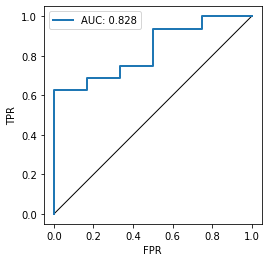

In [3]:
# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

# Print a user-friendly summary of the attacks
print(attacks_result.summary(by_slices = True))

Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Best-performing attacks over all slices
  THRESHOLD_ATTACK (with 12 training and 16 test examples) achieved an AUC of 0.83 on slice CLASS=29
  RANDOM_FOREST (with 12 training and 12 test examples) achieved an advantage of 0.67 on slice CLASS=29


slice feature slice value  train size  test size          attack type  \
5           class           0         177        177  K_NEAREST_NEIGHBORS   
8           class           1         101        101  K_NEAREST_NEIGHBORS   
11          class           2         574        574  K_NEAREST_NEIGHBORS   
14          class           3         129        129  K_NEAREST_NEIGHBORS   
17          class           4         306        306  K_NEAREST_NEIGHBORS   
..            ...         ...         ...        ...                  ...   
290         class          95         101        101  K_NEAREST_NEIGHBORS   
293         class          96         122        122  K_NEAREST_NEIGHBORS   
296         class          97         293        293  K_NEAREST_NEIGHBORS   
299         class          98         238        238  K_NEAREST_NEIGHBORS   
302         class          99         200        200  K_NEAREST_NEIGHBORS   

     Attacker advantage       AUC  
5              0.174242  0.582323  
8              0.210769  0.603846  
11             0.217706  0.616234  
14             0.223485  0.392045  
17             0.427033  0.734962  
..                  ...       ...  
290            0.576923  0.766154  
293            0.502151  0.796774  
296            0.188449  0.554517  
299            0.339266  0.701271  
302            0.280000  0.663000  

[100 rows x 7 columns]

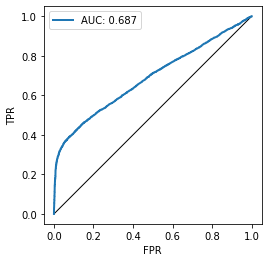

In [4]:
res_df = attacks_result.calculate_pd_dataframe()
print(attacks_result.summary(by_slices = False))

fig = plotting.plot_roc_curve(
    attacks_result.single_attack_results[1].roc_curve)

attack_types = [AttackType.THRESHOLD_ATTACK,
                AttackType.RANDOM_FOREST,
                AttackType.K_NEAREST_NEIGHBORS]

res_df.drop(res_df[res_df["slice feature"] == "Entire dataset"].index, inplace=True)
res_df.drop(res_df[res_df["slice feature"] == "correctly_classified"].index, inplace=True)

res_ta = res_df.loc[res_df['attack type'] == "THRESHOLD_ATTACK"]
res_rf = res_df.loc[res_df['attack type'] == "RANDOM_FOREST"]
res_knn = res_df.loc[res_df['attack type'] == "K_NEAREST_NEIGHBORS"]

res_knn

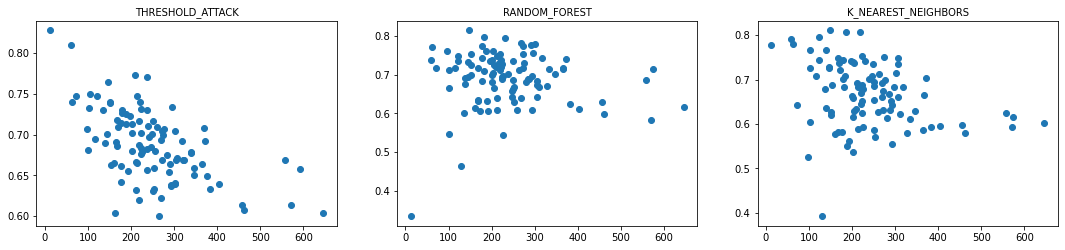

In [6]:
import matplotlib.pyplot as plt

fsize = (nbfuns._DEFAULT_FIGSIZE[0] * 3, nbfuns._DEFAULT_FIGSIZE[1])
fig, ax = plt.subplots(1, 3, figsize=fsize)
for i, atk_type in enumerate(attack_types):
    res = res_df.loc[res_df['attack type'] == str(atk_type)]
    ax[i].scatter(res["train size"], res["AUC"])
    ax[i].set_title(str(atk_type), fontsize="medium")
    #res.plot(
    #   x="train size",
    #    y=["AUC"],
    #    kind="scatter",
    #    layout=(1,2),
    #    xlabel="Class index",
    #    title="AUC: " + str(atk_type),
    #    )
#fig.suptitle('Purchase100 Small NN: Results Per Slices', fontsize="large")
#fig.subplots_adjust(top=0.88)
plt.savefig("./img/purchase100-atk-types/purchase100-dp.pdf", bbox_inches='tight')

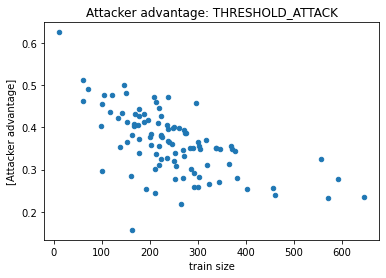

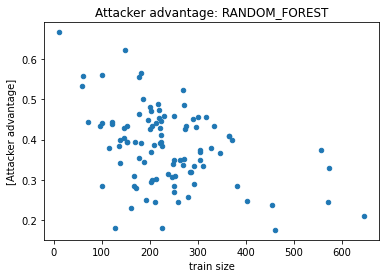

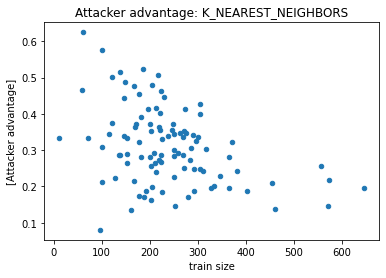

In [8]:
for atk_type in attack_types:
    res = res_df.loc[res_df['attack type'] == str(atk_type)]
    res.plot(
        x="train size",
        y=["Attacker advantage"],
        kind="scatter",
        layout=(1,2),
        xlabel="Class index",
        title="Attacker advantage: " + str(atk_type),
        )

<AxesSubplot:xlabel='train size', ylabel='AUC'>

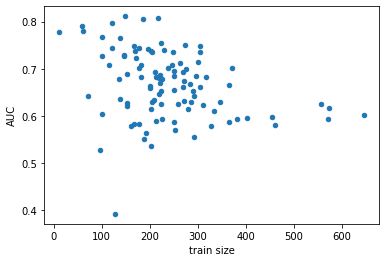

In [9]:
res_knn.plot(x='train size', y='AUC', kind='scatter')

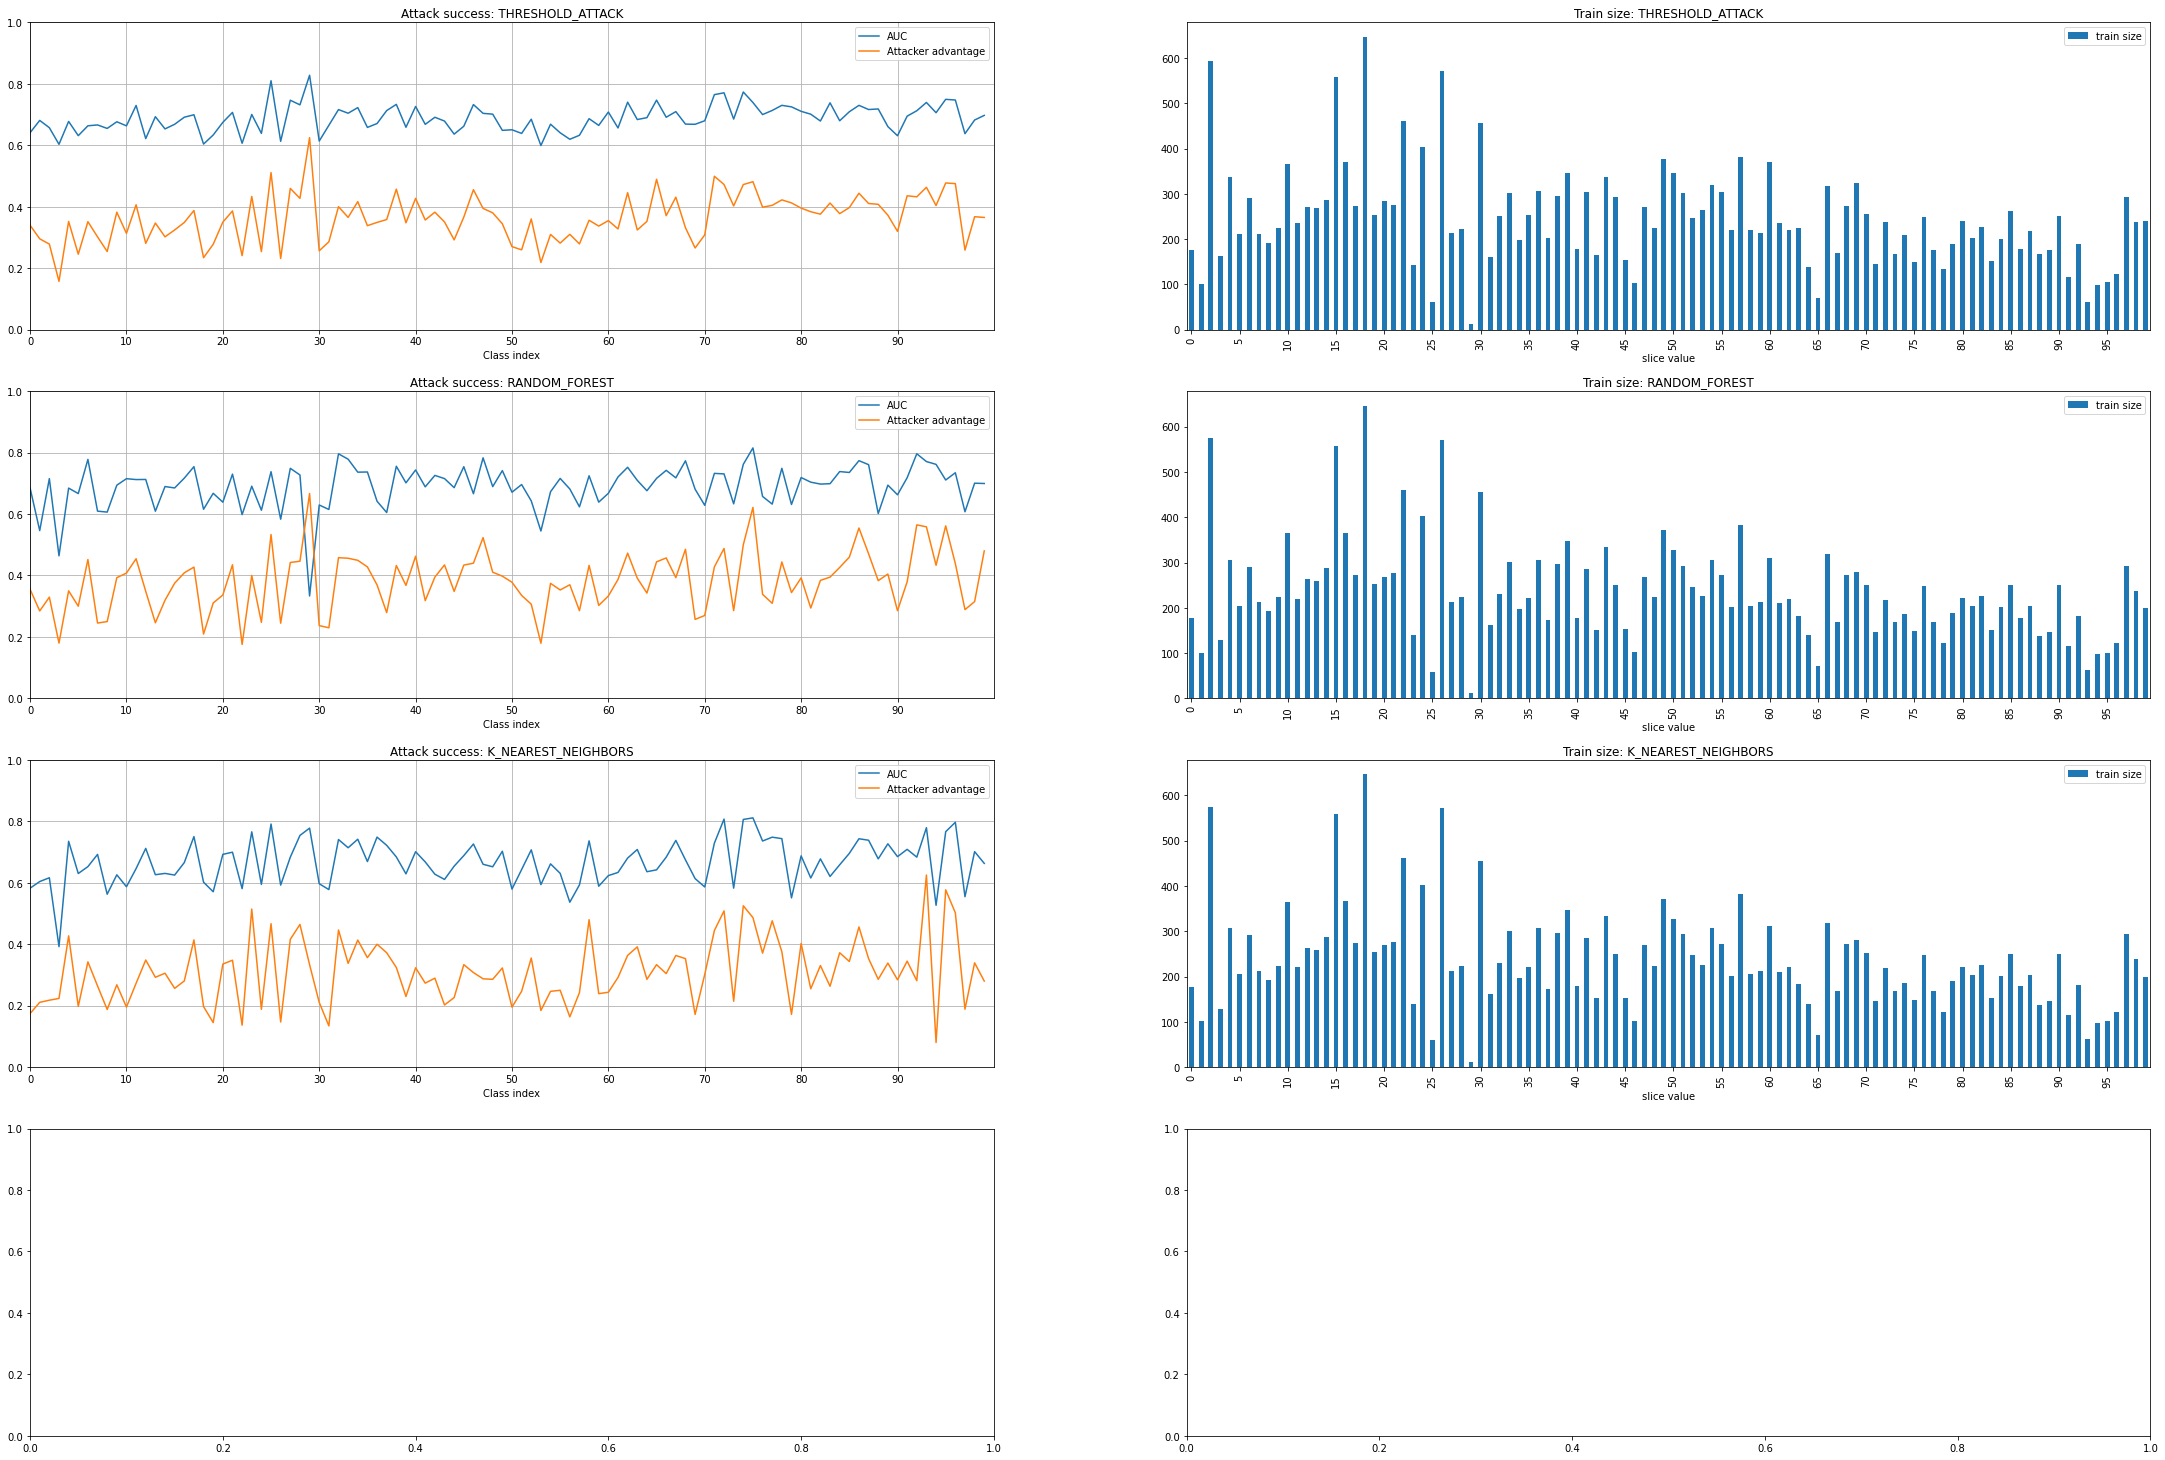

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(38,26))

for i, atk_type in enumerate(attack_types):
    res = res_df.loc[res_df['attack type'] == str(atk_type)]
    res.plot(
        x="slice value",
        y=["AUC", "Attacker advantage"],
        xlim=(0,100),
        ylim=(0,1),
        grid=True,
        xticks=range(0,100,10),
        xlabel="Class index",
        title="Attack success: " + str(atk_type),
        ax=axes[i, 0]
    )
    
    res.plot(
        x="slice value",
        y=["train size"],
        kind="bar",
        xlim=(0,100),
        #grid=True,
        xticks=range(0,100,5),
        #xlabel="Class index",
        title="Train size: " + str(atk_type),
        ax=axes[i, 1]
    )

In [11]:
(x_train, y_train), (x_test, y_test), (x_shadow, y_shadow) = experiments.data_utils.load_purchase100(shadow_size=0.75)

./datasets/dataset_purchase


In [12]:
model_weights_path="./trained_models/purchase100-dpsgd-weights-best-50-epochs.hdf5"
model = model_purchase100()
model.summary()

try:
    model.load_weights(model_weights_path)
    print("Loaded model weights successfully from file ", model_weights_path)
except:
    print("Unable to load model")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 1024)              615424    
                                                                 
 layer2 (Dense)              (None, 512)               524800    
                                                                 
 layer3 (Dense)              (None, 256)               131328    
                                                                 
 layer4 (Dense)              (None, 128)               32896     
                                                                 
 layer5 (Dense)              (None, 100)               12900     
                                                                 
Total params: 1,317,348
Trainable params: 1,317,348
Non-trainable params: 0
_________________________________________________________________


2022-06-10 22:15:27.220394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 22:15:27.255671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 22:15:27.255883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 22:15:27.256784: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Loaded model weights successfully from file  ./trained_models/purchase100-dpsgd-weights-best-50-epochs.hdf5


In [13]:
probs_train = model.predict(x_train)
probs_test = model.predict(x_test)
labels_train = np.argmax(y_train, axis=1)
labels_test = np.argmax(y_test, axis=1)

membership_probability_results = nbfuns.calculate_membership_probabilities(probs_train, probs_test, labels_train, labels_test)
threshold_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5]
print(membership_probability_results.summary(threshold_list=threshold_list))


Membership probability analysis over slice: "Entire dataset"
  with 0.6000 as the threshold on membership probability, the precision-recall pair is (0.6144, 0.4258)
  with 0.5000 as the threshold on membership probability, the precision-recall pair is (0.6007, 0.8482)
  thresholding on membership probability achieved an AUC of 0.67
  thresholding on membership probability achieved an advantage of 0.28

Membership probability analysis over slice: "CLASS=0"
  with 0.7000 as the threshold on membership probability, the precision-recall pair is (0.7582, 0.0678)
  with 0.6000 as the threshold on membership probability, the precision-recall pair is (0.6435, 0.6441)
  with 0.5000 as the threshold on membership probability, the precision-recall pair is (0.6195, 0.9153)
  thresholding on membership probability achieved an AUC of 0.72
  thresholding on membership probability achieved an advantage of 0.35

Membership probability analysis over slice: "CLASS=1"
  with 0.6000 as the threshold on me

In [14]:
#for member_probas in membership_probability_results.membership_prob_results:
#    results = member_probas.collect_results([0.5], return_roc_results=True)
#    print(results)

n_classes = 1
sorted_results = res_ta.sort_values(by="AUC")
least_vulnerable = sorted_results[:n_classes]
most_vulnerable = sorted_results[len(sorted_results) - n_classes:]
least_vulnerable

print(y_train.shape)

(24665, 100)


In [15]:
def extract_inputs_using_dataframe_to_empty_ndarray(x_train, y_train, df):
    ys = np.array([], dtype=np.int64).reshape(0,100)
    xs = np.array([], dtype=np.int64).reshape(0,600)
    
    for c in df["slice value"]:
        indices = np.where(np.argmax(y_train, axis=1) == int(c))
        xs_new = x_train[indices]
        ys_new = y_train[indices]
        xs = np.vstack([xs, xs_new])
        ys = np.vstack([ys, ys_new])

    return xs, ys

In [16]:
xs_lowest, ys_lowest = extract_inputs_using_dataframe_to_empty_ndarray(x_train, y_train, least_vulnerable)
xs_highest, ys_highest = extract_inputs_using_dataframe_to_empty_ndarray(x_train, y_train, most_vulnerable)
xs_final = np.vstack([xs_lowest, xs_highest])
ys_final = np.vstack([ys_lowest, ys_highest])
ys_final = np.argmax(ys_final, axis=1)

xs_lowest_test, ys_lowest_test = extract_inputs_using_dataframe_to_empty_ndarray(x_test, y_test, least_vulnerable)
xs_highest_test, ys_highest_test = extract_inputs_using_dataframe_to_empty_ndarray(x_test, y_test, most_vulnerable)
xs_final_test = np.vstack([xs_lowest_test, xs_highest_test])
ys_final_test = np.vstack([ys_lowest_test, ys_highest_test])
ys_final_test = np.argmax(ys_final_test, axis=1)

ys_lowest = np.argmax(ys_lowest, axis=1)
ys_lowest_test = np.argmax(ys_lowest_test, axis=1)

ys_highest = np.argmax(ys_highest, axis=1)
ys_highest_test = np.argmax(ys_highest_test, axis=1)

#print(ys_highest)

Samples with highest membership risk in class 53
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 265 samples in 0.000s...
[t-SNE] Computed neighbors for 265 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 265 / 265
[t-SNE] Mean sigma: 6.698409


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 122.297501
[t-SNE] KL divergence after 1000 iterations: 1.650095
t-SNE done! Time elapsed: 1.0490198135375977 seconds


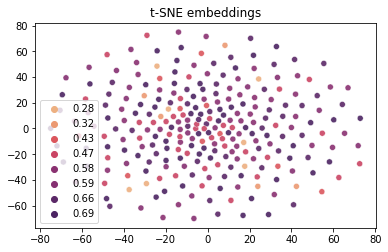

In [17]:
importlib.reload(nbfuns)

nbfuns.plot_class_membership_probabilities_with_luminance(
    model.predict(xs_lowest),
    model.predict(xs_lowest_test),
    ys_lowest,
    ys_lowest_test,
    xs_lowest,
    ys_lowest,
    use_tsne=True,
    luminance_colormap="flare"
)

Samples with highest membership risk in class 29


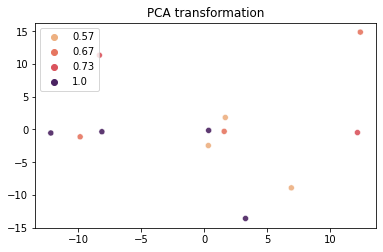

In [18]:
importlib.reload(nbfuns)

nbfuns.plot_class_membership_probabilities_with_luminance(
    model.predict(xs_highest),
    model.predict(xs_highest_test),
    ys_highest,
    ys_highest_test,
    xs_highest,
    ys_highest,
    use_tsne=False,
    luminance_colormap="flare"
)

Samples with highest membership risk in class 29


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


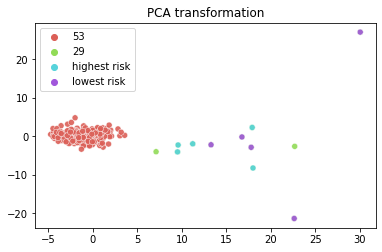

Samples with highest membership risk in class 53


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


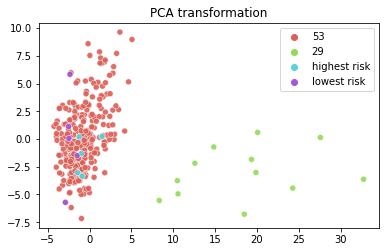

In [19]:
nbfuns.plot_membership_probabilities(
    model.predict(xs_final),
    model.predict(xs_final_test),
    ys_final,
    ys_final_test,
    xs_final,
    ys_final,
    num_samples=5,
    use_tsne=False
)

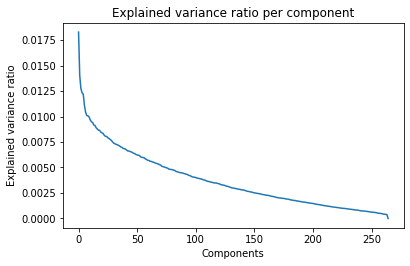

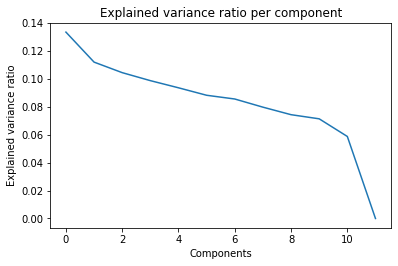

In [20]:
importlib.reload(nbfuns)

pca_lowest, res_lowest = nbfuns.plot_explained_variance_per_component(xs_lowest)
pca_highest, res_highest = nbfuns.plot_explained_variance_per_component(xs_highest)

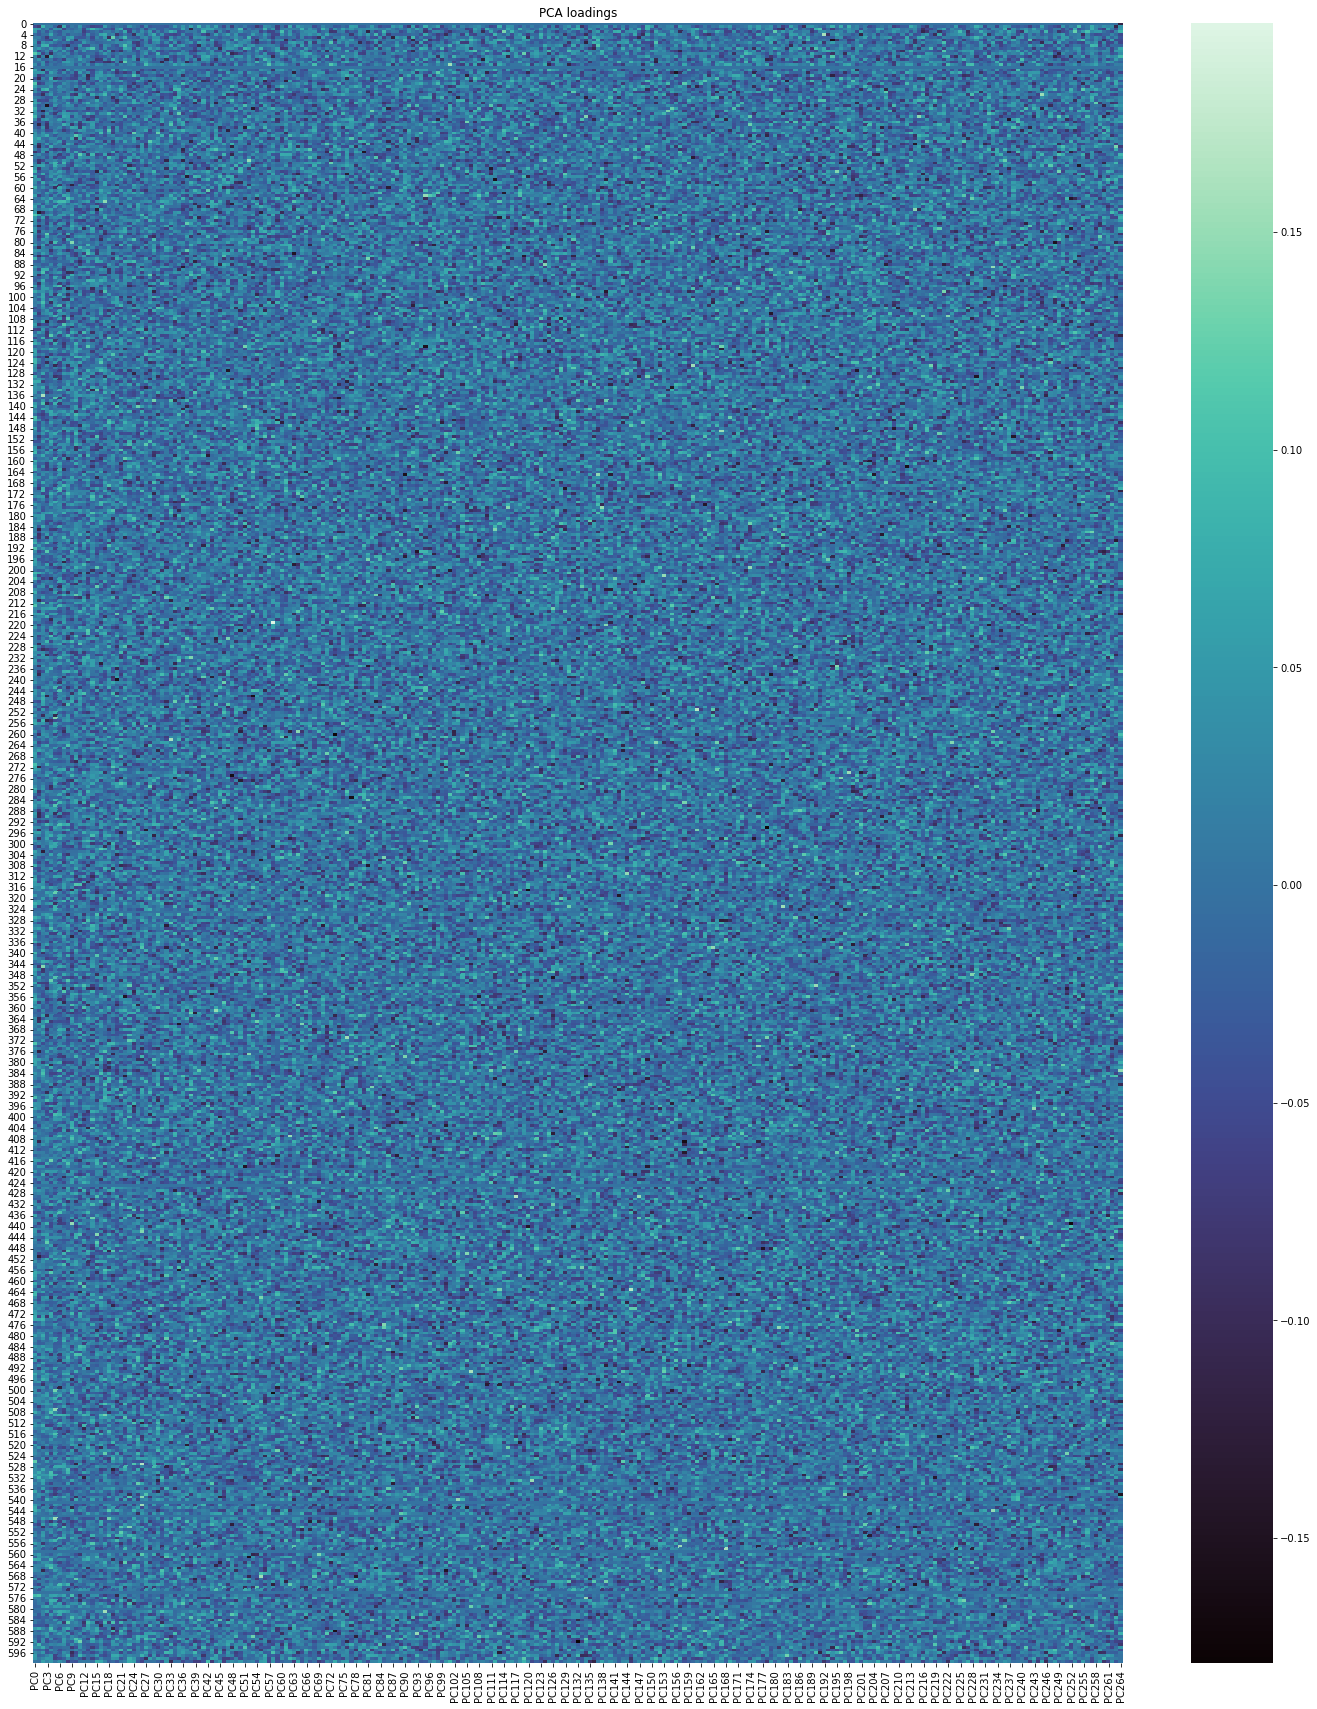

PC0           PC1           PC2           PC3           PC4  \
0    3.569000e-18 -8.416149e-18 -4.279180e-18 -2.783412e-18  1.647405e-17   
1   -5.090012e-02 -7.210468e-02  8.352510e-02  1.541924e-02  2.106449e-02   
2    6.166813e-02  4.990733e-02 -6.838666e-03  2.217670e-02 -3.075136e-02   
3    5.069020e-02 -2.984757e-02  9.166990e-03 -3.401272e-02  2.311504e-02   
4   -6.683687e-03 -3.417237e-02 -4.924457e-03 -4.263069e-03  6.984240e-02   
..            ...           ...           ...           ...           ...   
595 -7.995801e-03 -2.156657e-02 -1.476978e-02 -4.839694e-02  3.444178e-02   
596  3.173819e-02  8.221017e-03  4.947143e-02 -4.152598e-02 -2.267361e-02   
597  5.275947e-02 -1.612561e-02 -6.942238e-03  2.153858e-02  4.761464e-02   
598  4.719201e-02  7.284449e-03  3.003491e-02  5.234827e-02  4.538239e-02   
599  3.821391e-03 -1.901906e-03  5.556897e-02  2.587877e-02  4.474643e-02   

              PC5           PC6           PC7           PC8           PC9  \
0   -1.855599e-17 -4.272148e-17 -3.907292e-17  1.600123e-17 -3.097003e-17   
1   -2.187628e-02 -9.185888e-02  7.423338e-02 -2.857591e-02  5.441046e-03   
2    4.103034e-02  3.515728e-02 -5.889129e-02 -6.057121e-03 -1.670437e-02   
3   -1.561708e-02 -3.281777e-02  1.023354e-02  1.732484e-02  4.355192e-03   
4   -5.137118e-03 -2.917130e-02  1.278578e-02 -2.459279e-02  3.349379e-03   
..            ...           ...           ...           ...           ...   
595 -1.337059e-03 -4.522463e-02 -1.658622e-02 -2.750955e-03 -2.413268e-03   
596  4.722183e-03 -2.611092e-02  3.886395e-02  1.564570e-02 -9.773795e-02   
597 -6.041658e-02 -1.402814e-02  2.566674e-02  7.005100e-02 -7.858272e-02   
598 -6.385254e-02 -4.692516e-02 -2.547531e-02  3.021715e-02 -1.490585e-02   
599  6.684040e-03  3.976312e-02  1.176676e-02 -6.828469e-02 -3.358701e-02   

     ...         PC255         PC256         PC257         PC258  \
0    ... -1.220974e-17 -2.570629e-17  3.049667e-17  6.504860e-17   
1    ... -1.085682e-02  9.098258e-03  7.622550e-02  2.705643e-02   
2    ... -1.778301e-02  5.060382e-03  7.969561e-02  2.443825e-02   
3    ...  5.304405e-02  1.014471e-01  3.318262e-02  4.988209e-02   
4    ... -9.677265e-02  2.889275e-02 -2.482142e-02 -4.854382e-02   
..   ...           ...           ...           ...           ...   
595  ...  6.826668e-03 -7.166670e-02 -4.728866e-02  2.746512e-02   
596  ... -1.846547e-02 -2.503539e-03  1.445141e-02  7.050991e-03   
597  ... -2.448264e-02  3.412970e-02 -1.066445e-02  1.857560e-02   
598  ...  4.489048e-03  9.865450e-03 -5.419993e-02  1.595436e-02   
599  ...  4.804962e-02 -9.701608e-03 -5.734999e-02  2.154542e-04   

            PC259         PC260         PC261         PC262         PC263  \
0   -5.128206e-17  7.326444e-17 -1.449814e-16  6.348288e-17  2.384822e-17   
1    1.066439e-02  4.201760e-02  2.612585e-02  3.390511e-02 -1.080453e-01   
2   -4.475538e-02 -6.419978e-02  6.465955e-02  7.295634e-03 -4.451532e-02   
3    5.511190e-02 -3.210073e-03 -2.183811e-02 -4.954135e-02  2.234524e-02   
4   -4.190130e-02 -1.891133e-02 -2.087419e-02  2.832627e-02 -9.373725e-03   
..            ...           ...           ...           ...           ...   
595  5.483047e-02 -1.670271e-02 -3.066206e-03 -5.181986e-03  8.296965e-03   
596 -9.217247e-02 -8.809762e-02 -1.902557e-02 -2.356481e-02 -2.504406e-02   
597  3.496130e-02  2.921918e-02  5.912301e-02  4.487653e-02 -7.317868e-03   
598  2.625930e-02  8.739360e-02  7.587546e-03  1.596191e-02  8.645332e-03   
599  5.346301e-02 -8.399652e-02 -5.633849e-02  3.443555e-02 -3.678406e-02   

        PC264  
0   -0.115752  
1    0.044338  
2    0.053411  
3    0.088713  
4   -0.052209  
..        ...  
595 -0.043021  
596  0.006012  
597  0.000490  
598  0.000773  
599  0.000806  

[600 rows x 265 columns]

In [21]:
importlib.reload(nbfuns)

coef = 4
new_figsize = (nbfuns._DEFAULT_FIGSIZE[0] * coef, nbfuns._DEFAULT_FIGSIZE[1] * 2 * coef)
df_lowest = pd.DataFrame(xs_lowest)
nbfuns.plot_pca_loadings_heatmap_from_dataframe(df_lowest, pca_lowest, figsize=new_figsize)

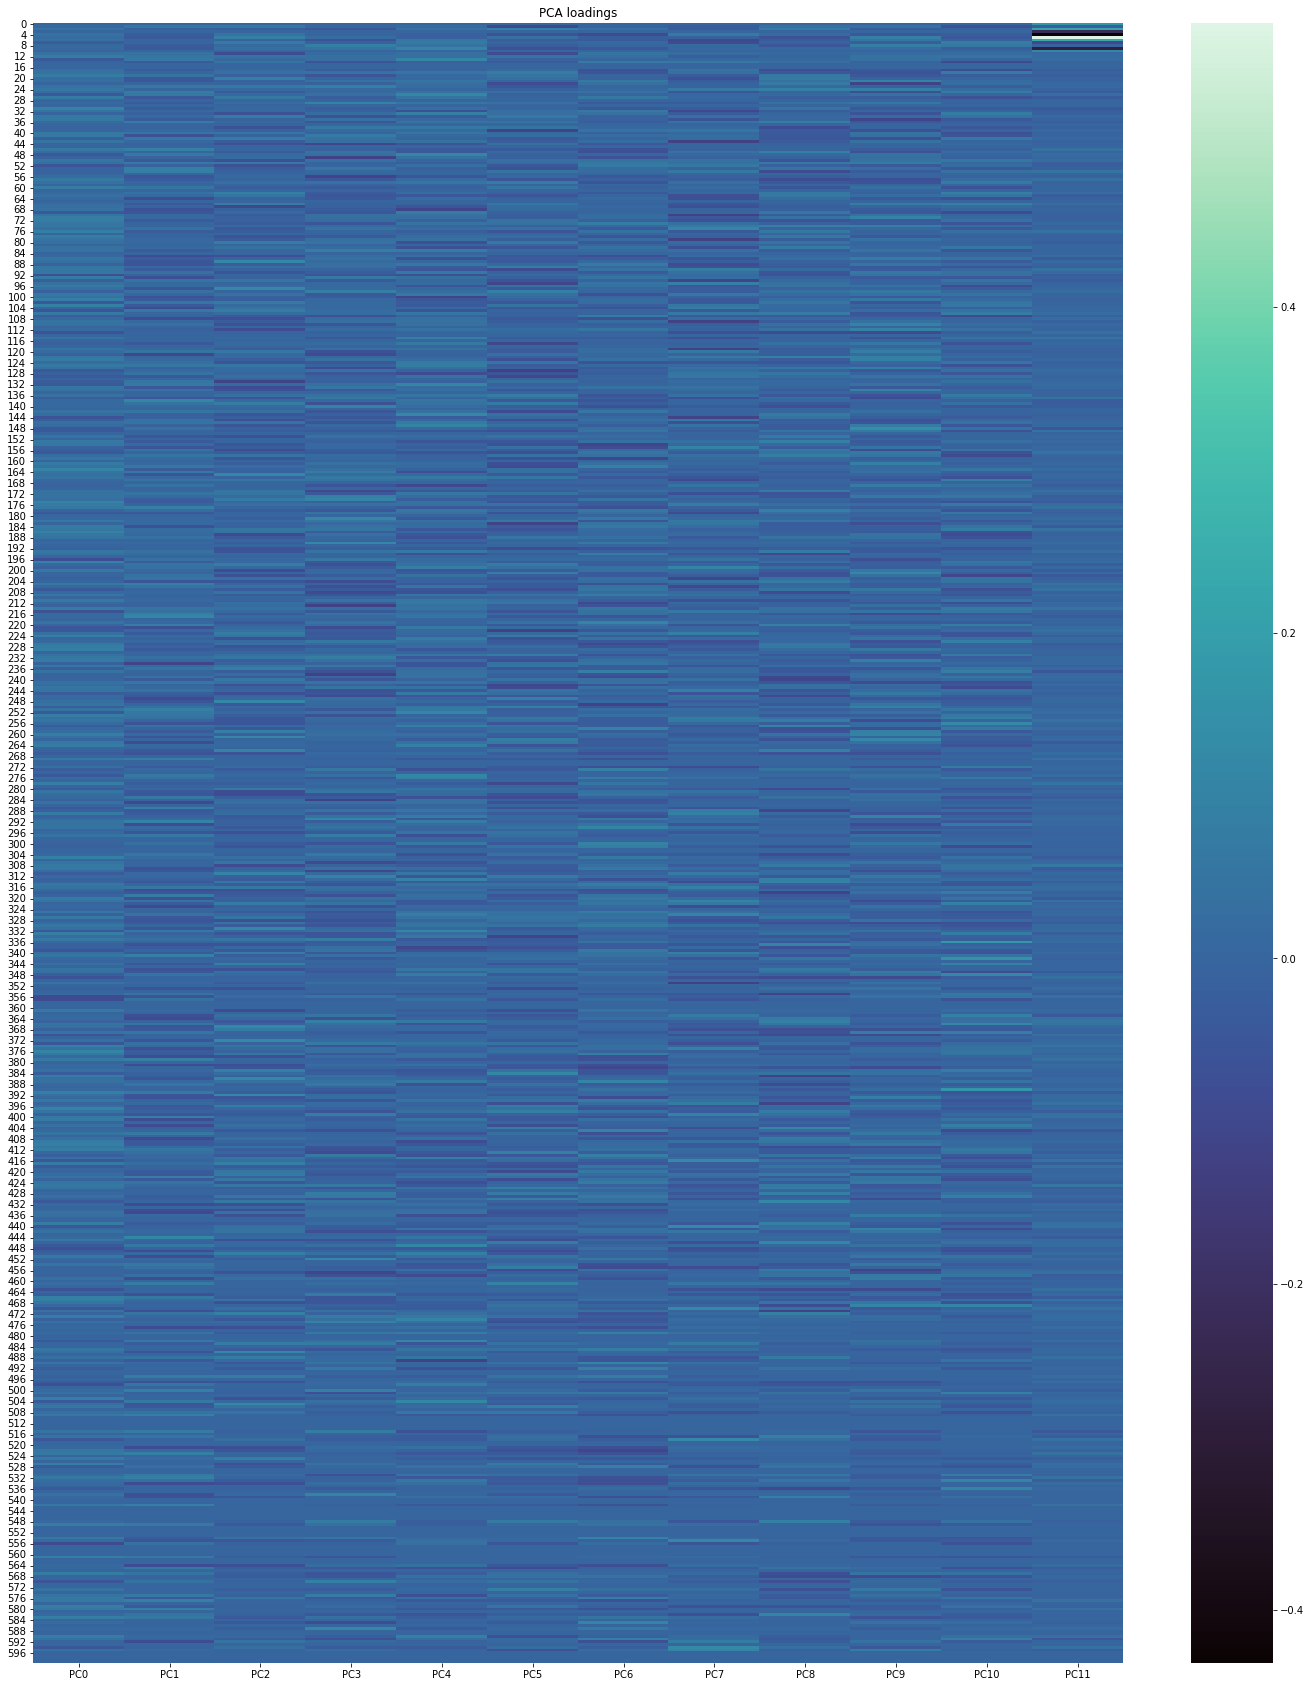

<Figure size 432x288 with 0 Axes>

In [22]:
importlib.reload(nbfuns)

df_highest = pd.DataFrame(xs_highest)
nbfuns.plot_pca_loadings_heatmap_from_dataframe(df_highest, pca_highest, figsize=new_figsize)
#plt.savefig("img/purchase100-loadings-heatmap-highest-risk.svg")
f = plt.gcf()
f.savefig("./img/purchase100-loadings-heatmap-highest-risk.svg")

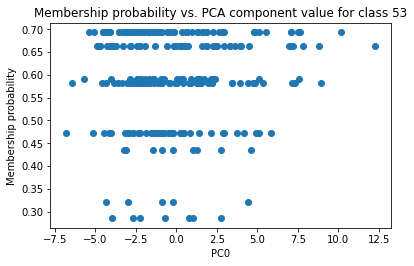

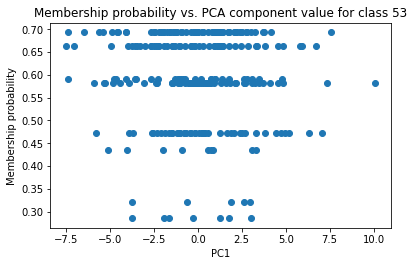

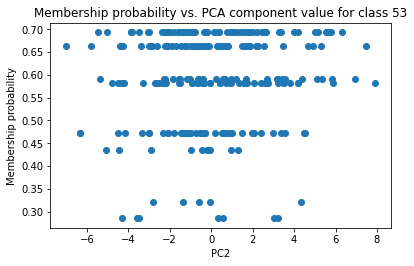

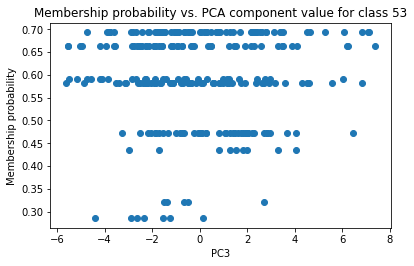

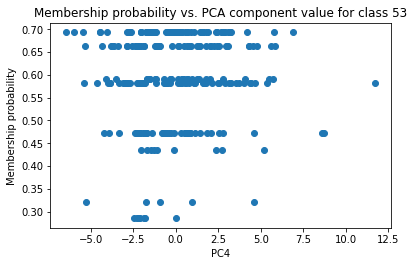

In [23]:
importlib.reload(nbfuns)

nbfuns.plot_pca_component_dependency_on_membership_risk(
    model.predict(xs_lowest),
    model.predict(xs_lowest_test),
    ys_lowest,
    ys_lowest_test,
    xs_lowest,
    ys_lowest,
    n_components=5
)

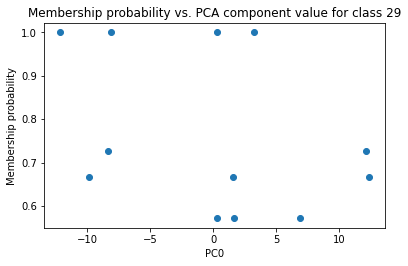

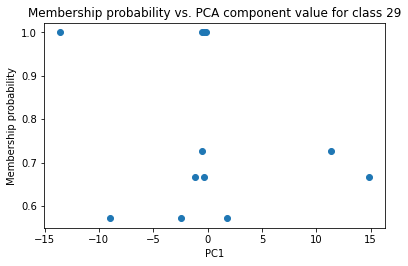

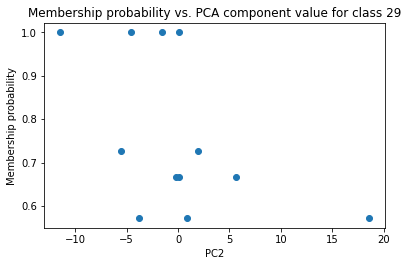

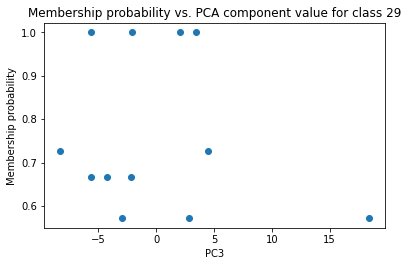

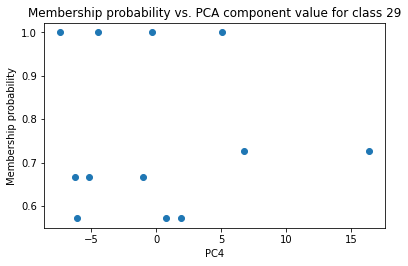

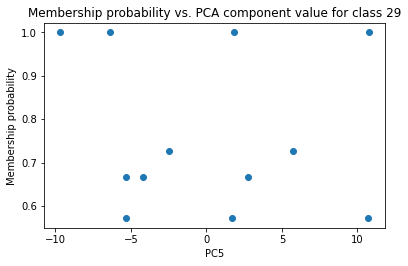

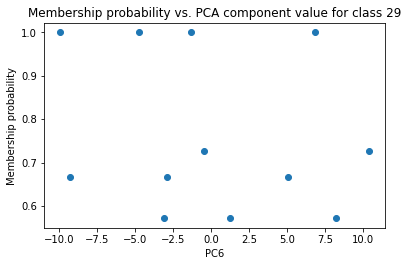

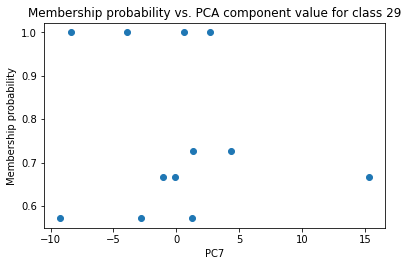

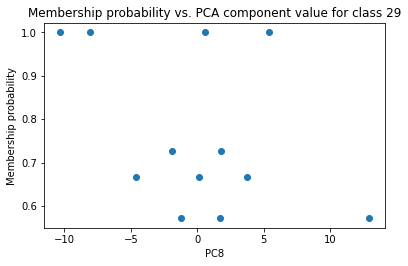

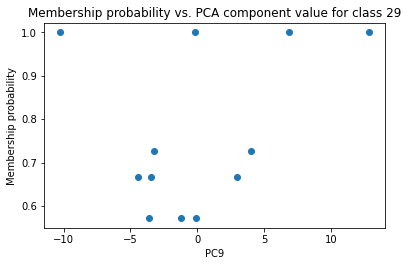

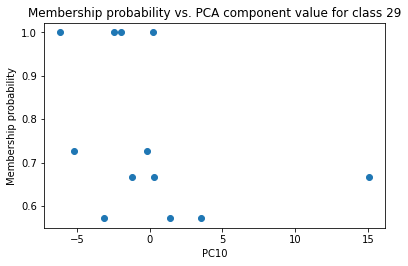

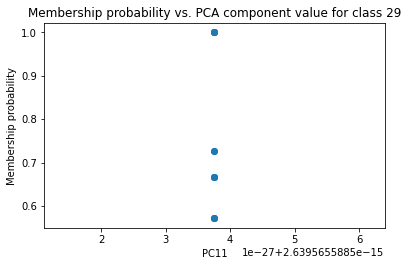

In [24]:
nbfuns.plot_pca_component_dependency_on_membership_risk(
    model.predict(xs_highest),
    model.predict(xs_highest_test),
    ys_highest,
    ys_highest_test,
    xs_highest,
    ys_highest,
)

In [25]:
df_lowest.describe()

0           1           2           3           4           5    \
count  265.0  265.000000  265.000000  265.000000  265.000000  265.000000   
mean     0.0    0.535849    0.169811    0.947170    0.094340    0.030189   
std      0.0    0.499657    0.376177    0.224118    0.292854    0.171430   
min      0.0    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.0    0.000000    0.000000    1.000000    0.000000    0.000000   
50%      0.0    1.000000    0.000000    1.000000    0.000000    0.000000   
75%      0.0    1.000000    0.000000    1.000000    0.000000    0.000000   
max      0.0    1.000000    1.000000    1.000000    1.000000    1.000000   

              6           7           8           9    ...         590  \
count  265.000000  265.000000  265.000000  265.000000  ...  265.000000   
mean     0.845283    0.822642    0.207547    0.120755  ...    0.041509   
std      0.362319    0.382695    0.406318    0.326459  ...    0.199843   
min      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
25%      1.000000    1.000000    0.000000    0.000000  ...    0.000000   
50%      1.000000    1.000000    0.000000    0.000000  ...    0.000000   
75%      1.000000    1.000000    0.000000    0.000000  ...    0.000000   
max      1.000000    1.000000    1.000000    1.000000  ...    1.000000   

              591         592         593         594         595         596  \
count  265.000000  265.000000  265.000000  265.000000  265.000000  265.000000   
mean     0.003774    0.052830    0.026415    0.022642    0.022642    0.007547   
std      0.061430    0.224118    0.160670    0.149039    0.149039    0.086710   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

              597         598         599  
count  265.000000  265.000000  265.000000  
mean     0.252830    0.026415    0.045283  
std      0.435457    0.160670    0.208318  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000  
75%      1.000000    0.000000    0.000000  
max      1.000000    1.000000    1.000000  

[8 rows x 600 columns]

In [26]:
r = df_highest.describe()

In [27]:
r

0          1          2     3          4          5          6    \
count  12.0  12.000000  12.000000  12.0  12.000000  12.000000  12.000000   
mean    0.0   0.333333   0.166667   1.0   0.333333   0.166667   0.833333   
std     0.0   0.492366   0.389249   0.0   0.492366   0.389249   0.389249   
min     0.0   0.000000   0.000000   1.0   0.000000   0.000000   0.000000   
25%     0.0   0.000000   0.000000   1.0   0.000000   0.000000   1.000000   
50%     0.0   0.000000   0.000000   1.0   0.000000   0.000000   1.000000   
75%     0.0   1.000000   0.000000   1.0   1.000000   0.000000   1.000000   
max     0.0   1.000000   1.000000   1.0   1.000000   1.000000   1.000000   

             7          8          9    ...        590        591        592  \
count  12.000000  12.000000  12.000000  ...  12.000000  12.000000  12.000000   
mean    0.416667   0.500000   0.250000  ...   0.500000   0.166667   0.333333   
std     0.514929   0.522233   0.452267  ...   0.522233   0.389249   0.492366   
min     0.000000   0.000000   0.000000  ...   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000  ...   0.000000   0.000000   0.000000   
50%     0.000000   0.500000   0.000000  ...   0.500000   0.000000   0.000000   
75%     1.000000   1.000000   0.250000  ...   1.000000   0.000000   1.000000   
max     1.000000   1.000000   1.000000  ...   1.000000   1.000000   1.000000   

        593        594        595   596   597   598   599  
count  12.0  12.000000  12.000000  12.0  12.0  12.0  12.0  
mean    0.0   0.083333   0.833333   0.0   0.0   0.0   0.0  
std     0.0   0.288675   0.389249   0.0   0.0   0.0   0.0  
min     0.0   0.000000   0.000000   0.0   0.0   0.0   0.0  
25%     0.0   0.000000   1.000000   0.0   0.0   0.0   0.0  
50%     0.0   0.000000   1.000000   0.0   0.0   0.0   0.0  
75%     0.0   0.000000   1.000000   0.0   0.0   0.0   0.0  
max     0.0   1.000000   1.000000   0.0   0.0   0.0   0.0  

[8 rows x 600 columns]